In [1]:
import numpy as np
import pandas as pd
import math
from collections import defaultdict
import matplotlib.pyplot as plt
import sklearn
import ast
from gensim import parsing
import csv

train = pd.read_csv(r"recipe_train.csv", index_col = False, delimiter = ',', header = 0)
test = pd.read_csv(r"recipe_test.csv", index_col = False, delimiter = ',', header = 0)

In [2]:
train_name = pd.read_csv(r"train_name_doc2vec100.csv", index_col = False, delimiter = ',', header = None)
train_ing = pd.read_csv(r"train_ingr_doc2vec100.csv", index_col = False, delimiter = ',', header = None)
train_steps = pd.read_csv(r"train_steps_doc2vec100.csv", index_col = False, delimiter = ',', header = None)

In [3]:
test_name = pd.read_csv(r"test_name_doc2vec100.csv", index_col = False, delimiter = ',', header = None)
test_ing = pd.read_csv(r"test_ingr_doc2vec100.csv", index_col = False, delimiter = ',', header = None)
test_steps = pd.read_csv(r"test_steps_doc2vec100.csv", index_col = False, delimiter = ',', header = None)

In [4]:
# Forming the train input features to predict on (no. of steps, no. of ingredients, and the 100 features
# from doc2vec100), as well as its ground truth labels

final_recipe = []

index = 0
for row in range(len(train_ing)):
    att_list = []
    att_list.append(train['n_steps'][index])
    att_list.append(train['n_ingredients'][index])
    for feat in train_ing:
        att_list.append(train_ing[feat][row])
    for feat in train_steps:
        att_list.append(train_steps[feat][row])
    for feat in train_name:
        att_list.append(train_name[feat][row])
    final_recipe.append(att_list)
    index += 1
    
final_recipe = np.array(final_recipe)
X_train = final_recipe
y_train = np.array(train['duration_label'])

In [5]:
# Forming the test input features to predict on (no. of steps, no. of ingredients, and the 100 features
# from doc2vec100)

final_recipe = []
index = 0
for row in range(len(test_ing)):
    att_list = []
    att_list.append(test['n_steps'][index])
    att_list.append(test['n_ingredients'][index])
    for feat in test_ing:
        att_list.append(test_ing[feat][row])
    for feat in test_steps:
        att_list.append(test_steps[feat][row])
    for feat in test_name:
        att_list.append(test_name[feat][row])    
    final_recipe.append(att_list)
    index += 1

final_recipe = np.array(final_recipe)
X_test = final_recipe

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

# to ignore long list of warnings for accuracies
import warnings; warnings.simplefilter('ignore')

Stacking = StackingClassifier(estimators = [('Standardised SVC', make_pipeline(StandardScaler(), LinearSVC())),
                                            ('LR', LogisticRegression()),
                                            ('GNB', GaussianNB()),
                                            ('Decision Tree', DecisionTreeClassifier())], 
                              final_estimator = LogisticRegression())

models = [GaussianNB(),
          DecisionTreeClassifier(),
          make_pipeline(StandardScaler(), LinearSVC()),
          LogisticRegression(),
          Stacking]

titles = ['GNB',
          'DecisionTree',
          'StandardisedLinearSVC',
          'LogisticRegression',
          'StackingClassifier']

# testing accuracies of different classifiers after training and predicting on the training set 
# using cross-validation with 10 partitions

total_acc = defaultdict(float)

for title, model in zip(titles, models):
    total_acc[title] = cross_val_score(model, X_train, y_train, cv = 10).mean()
            
for model in total_acc:
    print(model, total_acc[model])

GNB 0.607675
DecisionTree 0.5556
StandardisedLinearSVC 0.718575
LogisticRegression 0.723925
StackingClassifier 0.726625


In [12]:
# error rate for each model

for model in total_acc:
    print("Error Rate for " + model + ": " + str(1 - float(total_acc[model])))

Error Rate for GNB: 0.39232500000000003
Error Rate for DecisionTree: 0.4444
Error Rate for StandardisedLinearSVC: 0.28142500000000004
Error Rate for LogisticRegression: 0.27607499999999996
Error Rate for StackingClassifier: 0.27337500000000003


In [79]:
# getting the predicted labels for the training set for each model

pred_y_train = defaultdict()

for title, model in zip(titles, models):
    pred_y = []
    for i in range (0,10):
        curr_X_test = X_train[4000*i:4000*(i+1)]
        curr_X_train = np.concatenate((X_train[:4000*i], X_train[4000*(i+1):]), axis = 0)
        curr_y_train = np.concatenate((y_train[:4000*i], y_train[4000*(i+1):]), axis = 0)
        model.fit(curr_X_train,curr_y_train)
        pred_y.extend(model.predict(curr_X_test).tolist())
    pred_y_train[title] = np.array(pred_y)

In [94]:
# calculating the macro, micro, and weighted averaging for Precision

from sklearn.metrics import precision_score

method_precisions = defaultdict()
average = ['macro', 'micro', 'weighted']
    
for method in average:
    method_models = defaultdict()
    print(method[0].upper() + method[1:] + " Averaging Precision:")
    for title in pred_y_train:
        curr_result = precision_score(y_train, pred_y_train[title], average = method)
        method_models[title] = curr_result
        print(title + ": " + str(curr_result))
    method_precisions[method] = method_models
    print("")

Macro Averaging Precision:
GNB: 0.5249709123791567
DecisionTree: 0.4211784594533096
StandardisedLinearSVC: 0.7199050977957403
LogisticRegression: 0.684373287301478
StackingClassifier: 0.7025155470839755

Micro Averaging Precision:
GNB: 0.607625
DecisionTree: 0.55825
StandardisedLinearSVC: 0.719225
LogisticRegression: 0.724125
StackingClassifier: 0.727525

Weighted Averaging Precision:
GNB: 0.6158412035825978
DecisionTree: 0.5609580388840013
StandardisedLinearSVC: 0.7195424207506288
LogisticRegression: 0.7207117864812979
StackingClassifier: 0.7253376634101197



In [96]:
# calculating the macro, micro, and weighted averaging for Recall

from sklearn.metrics import recall_score

method_recalls = defaultdict()

for method in average:
    method_models = defaultdict()
    print(method[0].upper() + method[1:] + " Averaging Recall:")
    for title in pred_y_train:
        curr_result = recall_score(y_train, pred_y_train[title], average = method)
        method_models[title] = curr_result
        print(title + ": " + str(curr_result))
    method_recalls[method] = method_models
    print("")

Macro Averaging Recall:
GNB: 0.5371557233497738
DecisionTree: 0.4223069223437424
StandardisedLinearSVC: 0.5565846795050462
LogisticRegression: 0.5930495640769664
StackingClassifier: 0.6039317386356315

Micro Averaging Recall:
GNB: 0.607625
DecisionTree: 0.55825
StandardisedLinearSVC: 0.719225
LogisticRegression: 0.724125
StackingClassifier: 0.727525

Weighted Averaging Recall:
GNB: 0.607625
DecisionTree: 0.55825
StandardisedLinearSVC: 0.719225
LogisticRegression: 0.724125
StackingClassifier: 0.727525



In [95]:
# calculating the macro, micro, and weighted averaging for F1 Score

for method in average:
    print(method[0].upper() + method[1:] + " Averaging F1-Score:")
    for title in pred_y_train:
        curr_result = (2*(method_precisions[method][title]*method_recalls[method][title])/
                       (method_precisions[method][title]+method_recalls[method][title]))
        print(title + ": " + str(curr_result))
    print("")

Macro Averaging F1-Score:
GNB: 0.5309934252483707
DecisionTree: 0.42174193603749194
StandardisedLinearSVC: 0.6277968774304952
LogisticRegression: 0.6354470319081859
StackingClassifier: 0.6495041023186685

Micro Averaging F1-Score:
GNB: 0.607625
DecisionTree: 0.55825
StandardisedLinearSVC: 0.719225
LogisticRegression: 0.724125
StackingClassifier: 0.7275250000000001

Weighted Averaging F1-Score:
GNB: 0.6117055137790134
DecisionTree: 0.5596007432527925
StandardisedLinearSVC: 0.7193836753606444
LogisticRegression: 0.7224143616342305
StackingClassifier: 0.7264296851484108



In [7]:
# writing the predicted duration labels (class labels) of the test set for each model

pred_y_tests = defaultdict()
    
for title, model in zip(titles, models):
    model.fit(X_train,y_train)
    pred_y_tests[title] = model.predict(X_test)

In [8]:
# create CSVs for each model's predicted duration labels

for model,labels in pred_y_tests.items():
    filename = model + ".csv"
    f = open(filename, "w+")
    f.write("id,duration_label\n")
    
    count = 1
    for label in labels:
        string = str(count) + "," + str(label) + "\n"
        f.write(string)
        count += 1
    
    f.close()

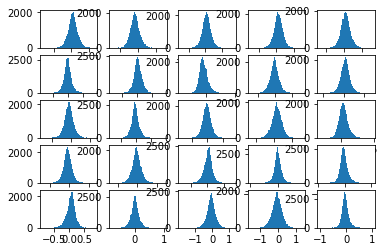

In [185]:
# selects 25 random features out of the 300 from Doc2Vec100 and plots points based on value against frequency, 
# most resulting in normal distributions

import random as rand

random_list = []
i = 25
while (i > 0):
    random_list.append(rand.randint(2,302))
    i -= 1

index = 1
for i in random_list:
    plt.subplot(5,5,index)
    plt.hist(X_train[:,i], bins = 100)
    index += 1
    
plt.show()

In [208]:
# finds the number of instances in each class in the training data

count = defaultdict()

for i in range(1,4):
    count[i] = 0

for label in y_train:
    if (label == 1):
        count[1] += 1
    elif (label == 2):
        count[2] += 1
    else:
        count[3] += 1

for i in count:
    print("Class " + str(i) + " has " + str(count[i]) + " instances")

Class 1 has 17705 instances
Class 2 has 20246 instances
Class 3 has 2049 instances


In [221]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, pred_y_train['GNB'], labels = [1,2,3])

array([[12062,  5141,   502],
       [ 7643, 11501,  1102],
       [  774,   533,   742]])

In [222]:
confusion_matrix(y_train, pred_y_train['DecisionTree'], labels = [1,2,3])

array([[ 9953,  6846,   906],
       [ 6943, 12164,  1139],
       [  831,  1005,   213]])

In [223]:
confusion_matrix(y_train, pred_y_train['StandardisedLinearSVC'], labels = [1,2,3])

array([[13128,  4522,    55],
       [ 4879, 15286,    81],
       [  658,  1036,   355]])

In [224]:
confusion_matrix(y_train, pred_y_train['LogisticRegression'], labels = [1,2,3])

array([[13024,  4541,   140],
       [ 4640, 15357,   249],
       [  549,   916,   584]])

In [225]:
confusion_matrix(y_train, pred_y_train['StackingClassifier'], labels = [1,2,3])

array([[12969,  4622,   114],
       [ 4525, 15488,   233],
       [  508,   897,   644]])

Citation:

Majumder, B. P., Li, S., Ni, J. & McAuley, J. Generating personalized recipes from historical user preferences. Proceedings of the 2019 Conference on Empirical Methods in Natural Language Processing and the 9th International Joint Conference on Natural Language Processing (EMNLP-IJCNLP), 2019.